In [148]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
data = pd.read_csv('./merge_v3_0.csv', sep=';')
# TODO enlever gironde
df = data
df

,faits,tauxpourmille,Code département,Tableau1AutresdpensesdaidesocialeTotalnetpardpartement31_2021,Tableau1Dpensesnettestotalesdaideauxpersonnesgespardpartement3_2021,Tableau1Dpensesnettestotalesdaidesocialelenfancepardpartementhorsdpensesdepersonnellexceptiondecellesliesauxassistantsfamiliaux18_2021,Tableau1Dpensestotalesnettesdaidesocialeycomprislaidemdicalegnralelesfraiscommunsetlesdpensesdepersonnelpardpartement1_2021,Tableau2AutresdpensesdaidesocialeTotalbrutpardpartement32_2021,Tableau2Dpensesbrutestotalesdaideauxpersonnesgespardpartement4_2021,Tableau2Dpensesbrutestotalesdaidesocialelenfancepardpartementhorsdpensesdepersonnellexceptiondecellesliesauxassistantsfamiliaux19_2021,...,[5;10[,[60;65[,[65;70[,[70;75[,[75;80[,[80;85[,[85;90[,[90;95[,[95;99+],Nombre de créations d'entreprises
0,24042,40.0,1,28330.402,57871.872,58489.972,271646.079,29370.243,58953.440,61402.876,...,45890,39970,35690,32640,22900,15440,11100,5930,2350,8417
1,22815,46.4,2,20410.185,79422.249,69917.258,378500.838,22234.394,80497.863,74140.992,...,32450,35000,33460,31240,19340,13610,10650,5330,1630,4422
2,12755,39.5,3,19504.452,62041.207,45931.680,241149.189,21141.589,62464.142,47682.243,...,16370,24080,24080,24520,17370,12830,10010,5390,1890,3355
3,7983,48.9,4,-363.542,21691.652,21916.247,90585.188,1770.574,21837.525,22340.995,...,8640,12230,12150,11670,8430,6140,4370,2210,870,2629
4,6136,43.6,5,11209.211,18581.219,11538.917,83203.517,13788.194,19099.139,12081.292,...,7350,10730,10350,9670,6820,4700,3650,1940,660,2484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,67826,55.6,91,41227.902,161867.162,343800.984,1356769.043,44195.407,191048.341,375709.749,...,92160,69800,56800,52300,37100,27250,20400,9930,3410,23093
89,95239,61.5,92,124030.658,126776.542,92724.684,855031.794,125753.524,132466.699,137897.228,...,107350,82630,67350,63950,45290,32970,24960,13900,5940,36273
90,132018,84.4,93,68718.570,81546.883,149803.225,670707.035,72036.717,88439.622,155827.168,...,123560,81500,66240,55740,35650,24680,17560,8220,2840,38726
91,86522,65.7,94,185727.703,80791.628,65466.919,475640.315,188315.073,81005.829,65467.169,...,90800,75660,61790,55820,38410,27780,21500,11580,4540,28800


In [150]:

# Prendre les colonnes intéressantes
colonnes_a_garder = ['code_departement','tauxpourmille','gagnant']


df_winner = df
df_winner.drop(columns=['DLF', 'EELV', 'LFI', 'LR', 'LO', 'LREM', 'NPA', 'PCF', 'PS', 'RN', 'Reconuête', 'Résistons', 'abstentions', 'blancs', 'nuls', 'faits', 'code_departement_1', 'Département', 'Code département'], inplace=True)
df_winner.columns = df_winner.columns.str.strip('[]')

# df_winner = df[colonnes_a_garder]
df_winner

,tauxpourmille,Tableau1AutresdpensesdaidesocialeTotalnetpardpartement31_2021,Tableau1Dpensesnettestotalesdaideauxpersonnesgespardpartement3_2021,Tableau1Dpensesnettestotalesdaidesocialelenfancepardpartementhorsdpensesdepersonnellexceptiondecellesliesauxassistantsfamiliaux18_2021,Tableau1Dpensestotalesnettesdaidesocialeycomprislaidemdicalegnralelesfraiscommunsetlesdpensesdepersonnelpardpartement1_2021,Tableau2AutresdpensesdaidesocialeTotalbrutpardpartement32_2021,Tableau2Dpensesbrutestotalesdaideauxpersonnesgespardpartement4_2021,Tableau2Dpensesbrutestotalesdaidesocialelenfancepardpartementhorsdpensesdepersonnellexceptiondecellesliesauxassistantsfamiliaux19_2021,Tableau2Dpensestotalesbrutesdaidesocialeycomprislaidemdicalegnralelesfraiscommunsetlesdpensesdepersonnelpardpartement2_2021,Tableau3Dpensesbrutesdaidedomicilepardpartement13_2021,...,5;10,60;65,65;70,70;75,75;80,80;85,85;90,90;95,95;99+,Nombre de créations d'entreprises
0,40.0,28330.402,57871.872,58489.972,271646.079,29370.243,58953.440,61402.876,282716.891,21092.960,...,45890,39970,35690,32640,22900,15440,11100,5930,2350,8417
1,46.4,20410.185,79422.249,69917.258,378500.838,22234.394,80497.863,74140.992,386638.100,18560.380,...,32450,35000,33460,31240,19340,13610,10650,5330,1630,4422
2,39.5,19504.452,62041.207,45931.680,241149.189,21141.589,62464.142,47682.243,250660.371,16876.566,...,16370,24080,24080,24520,17370,12830,10010,5390,1890,3355
3,48.9,-363.542,21691.652,21916.247,90585.188,1770.574,21837.525,22340.995,93450.437,4678.180,...,8640,12230,12150,11670,8430,6140,4370,2210,870,2629
4,43.6,11209.211,18581.219,11538.917,83203.517,13788.194,19099.139,12081.292,88577.502,6361.786,...,7350,10730,10350,9670,6820,4700,3650,1940,660,2484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,55.6,41227.902,161867.162,343800.984,1356769.043,44195.407,191048.341,375709.749,1443808.961,85068.051,...,92160,69800,56800,52300,37100,27250,20400,9930,3410,23093
89,61.5,124030.658,126776.542,92724.684,855031.794,125753.524,132466.699,137897.228,916457.165,42049.724,...,107350,82630,67350,63950,45290,32970,24960,13900,5940,36273
90,84.4,68718.570,81546.883,149803.225,670707.035,72036.717,88439.622,155827.168,698348.139,36439.128,...,123560,81500,66240,55740,35650,24680,17560,8220,2840,38726
91,65.7,185727.703,80791.628,65466.919,475640.315,188315.073,81005.829,65467.169,479161.214,23769.227,...,90800,75660,61790,55820,38410,27780,21500,11580,4540,28800


In [151]:

df_winner.dtypes

tauxpourmille                                                                                                                             float64
Tableau1AutresdpensesdaidesocialeTotalnetpardpartement31_2021                                                                             float64
Tableau1Dpensesnettestotalesdaideauxpersonnesgespardpartement3_2021                                                                       float64
Tableau1Dpensesnettestotalesdaidesocialelenfancepardpartementhorsdpensesdepersonnellexceptiondecellesliesauxassistantsfamiliaux18_2021    float64
Tableau1Dpensestotalesnettesdaidesocialeycomprislaidemdicalegnralelesfraiscommunsetlesdpensesdepersonnelpardpartement1_2021               float64
Tableau2AutresdpensesdaidesocialeTotalbrutpardpartement32_2021                                                                            float64
Tableau2Dpensesbrutestotalesdaideauxpersonnesgespardpartement4_2021                                                         

In [152]:
# Diviser les données en features (X) et la cible (y)
X = df_winner.drop(columns=['gagnant'])
y = df_winner['gagnant']

# Convertir les colonnes catégoriques en type 'category'
# cat_cols = X.select_dtypes(include=['object']).columns
# X[cat_cols] = X[cat_cols].astype('category')

# Encoder les catégories en valeurs numériques
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Créer un objet DMatrix pour XGBoost
dtrain = xgb.DMatrix(X, label=y)

# Spécifier les paramètres du modèle XGBoost
params = {
    'objective': 'multi:softmax',  # Pour une classification multi-classes
    'num_class': len(np.unique(y)),  # Nombre de classes dans la cible
    'eval_metric': 'merror'         # Métrique d'évaluation
}


num_rounds = 200  # Nombre d'itérations d'entraînement
cv_results = xgb.cv(params, dtrain, num_boost_round=num_rounds, nfold=30, metrics='merror', early_stopping_rounds=10, seed=42)


print(cv_results)
print("Précision moyenne :", 1 - cv_results['test-merror-mean'].iloc[-1])

    train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
0            0.031153          0.019374          0.327778         0.286205
1            0.018548          0.010100          0.300000         0.251477
2            0.006687          0.009370          0.300000         0.236291
3            0.003350          0.005882          0.288889         0.257061
4            0.001490          0.003798          0.266667         0.252212
5            0.000745          0.002787          0.255556         0.241459
6            0.000000          0.000000          0.255556         0.241459
7            0.000000          0.000000          0.255556         0.241459
8            0.000000          0.000000          0.255556         0.241459
9            0.000000          0.000000          0.255556         0.241459
10           0.000000          0.000000          0.255556         0.225599
Précision moyenne : 0.7444444444444445


In [153]:
# Entraîner un modèle XGBoost sur l'ensemble des données
model = xgb.train(params, dtrain, num_boost_round=num_rounds)

# Obtenir l'importance des caractéristiques
importance = model.get_score(importance_type='weight')

# Afficher l'importance des caractéristiques
print(importance)


{'tauxpourmille': 60.0, 'Tableau1AutresdpensesdaidesocialeTotalnetpardpartement31_2021': 10.0, 'Tableau1Dpensesnettestotalesdaideauxpersonnesgespardpartement3_2021': 15.0, 'Tableau1Dpensesnettestotalesdaidesocialelenfancepardpartementhorsdpensesdepersonnellexceptiondecellesliesauxassistantsfamiliaux18_2021': 14.0, 'Tableau1Dpensestotalesnettesdaidesocialeycomprislaidemdicalegnralelesfraiscommunsetlesdpensesdepersonnelpardpartement1_2021': 31.0, 'Tableau2AutresdpensesdaidesocialeTotalbrutpardpartement32_2021': 22.0, 'Tableau2Dpensesbrutestotalesdaideauxpersonnesgespardpartement4_2021': 16.0, 'Tableau2Dpensesbrutestotalesdaidesocialelenfancepardpartementhorsdpensesdepersonnellexceptiondecellesliesauxassistantsfamiliaux19_2021': 1.0, 'Tableau3Dpensesbrutesdaidedomicilepardpartement13_2021': 6.0, 'Tableau3Dpensesbrutestotalesdallocationspardpartement20_2021': 15.0, 'Tableau4DpensesbrutesdactionsducativesAEDetAEMOhorsdpensesdepersonnelsdpartementauxpardpartement21_2021': 55.0, 'Tableau4Dpen

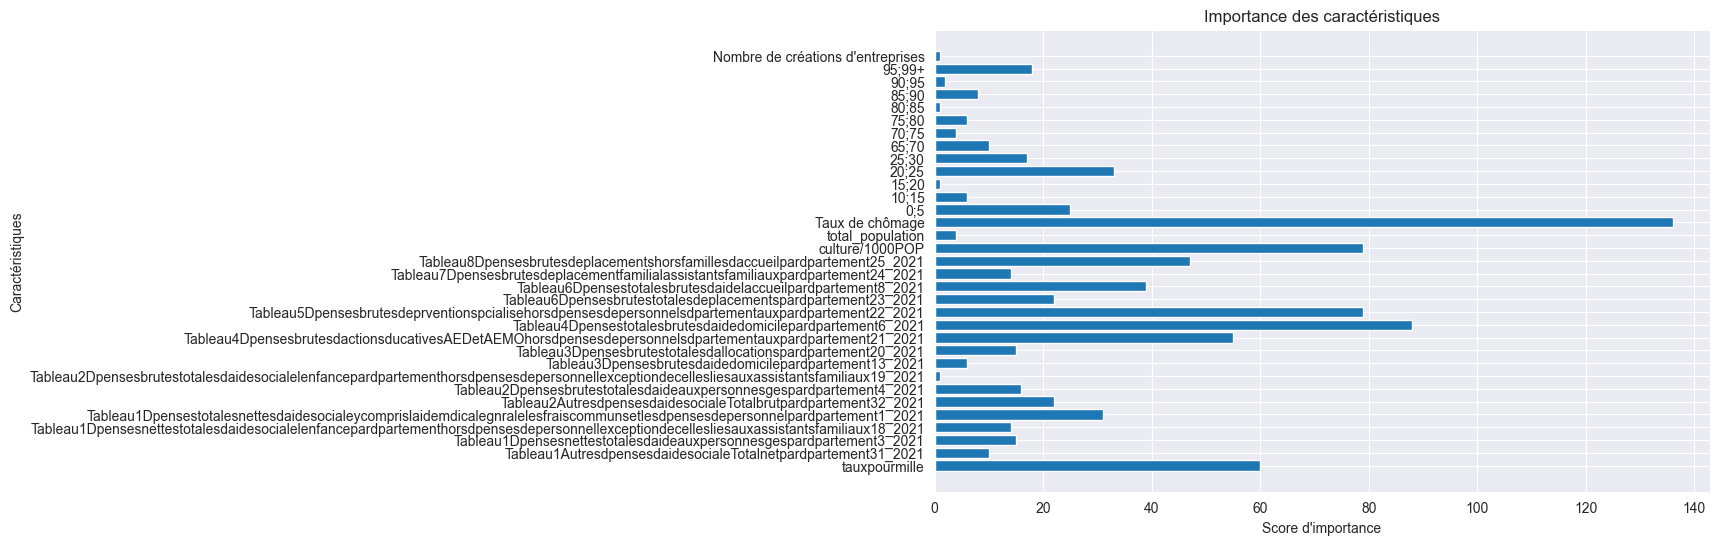

In [154]:

# Créer une liste de noms de caractéristiques et une liste de scores d'importance
feature_names = list(importance.keys())
scores = list(importance.values())

# Créer un graphique à barres pour afficher l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plt.barh(feature_names, scores)
plt.xlabel('Score d\'importance')
plt.ylabel('Caractéristiques')
plt.title('Importance des caractéristiques')
plt.show()

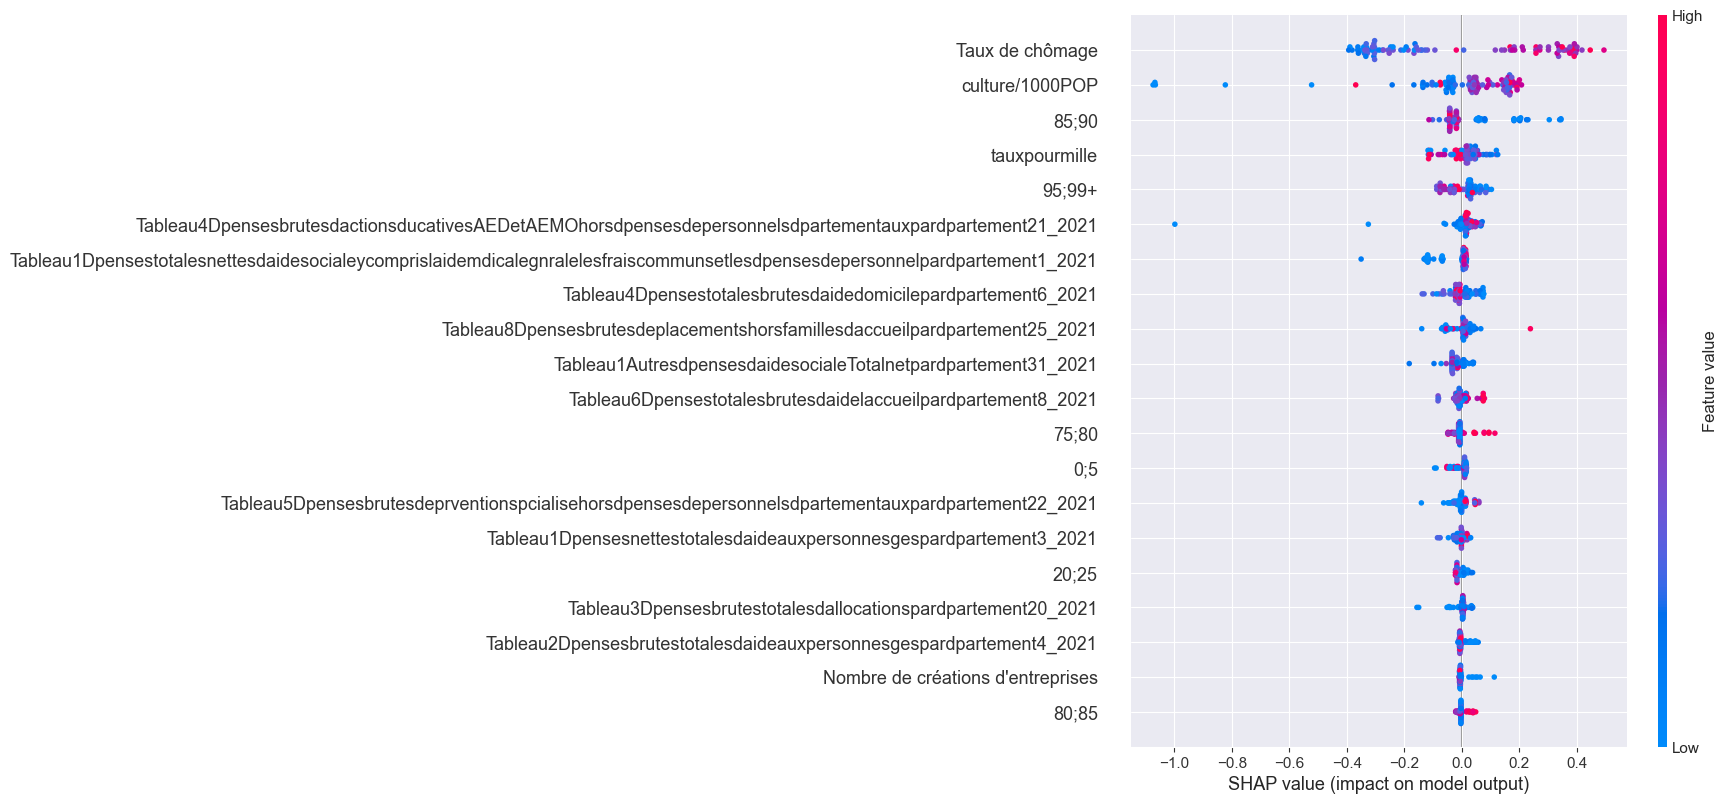

In [155]:
import shap

X2 = X

dtrain2 = xgb.DMatrix(X2, label=y)

params2 = {
    'eval_metric': 'merror'         # Métrique d'évaluation
}

model2 = xgb.train(params2, dtrain2, num_boost_round=num_rounds)


explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X2)

# Afficher le résumé des valeurs SHAP
shap.summary_plot(shap_values, X2)

In [156]:
# Analyse des différents impact par parties

# Créer un ensemble de données pour LREM
data_LREM = df_winner[df_winner['gagnant'] == 'LREM']

# Initialiser l'explorateur SHAP avec votre modèle XGBoost
explainer = shap.TreeExplainer(model2)

# Calculer les valeurs SHAP pour chaque ensemble de données

# Pour LREM
shap_values_LREM = explainer.shap_values(data_LREM.drop(columns=['gagnant']))

In [157]:
# Créer un ensemble de données pour RN
data_RN = df_winner[df_winner['gagnant'] == 'RN  ']
# Calculer les valeurs SHAP pour chaque ensemble de données
shap_values_RN = explainer.shap_values(data_RN.drop(columns=['gagnant']))

In [158]:
# Créer un ensemble de données pour LFI
data_LFI = df_winner[df_winner['gagnant'] == 'LFI ']
# Calculer les valeurs SHAP pour chaque ensemble de données
shap_values_LFI = explainer.shap_values(data_LFI.drop(columns=['gagnant']))

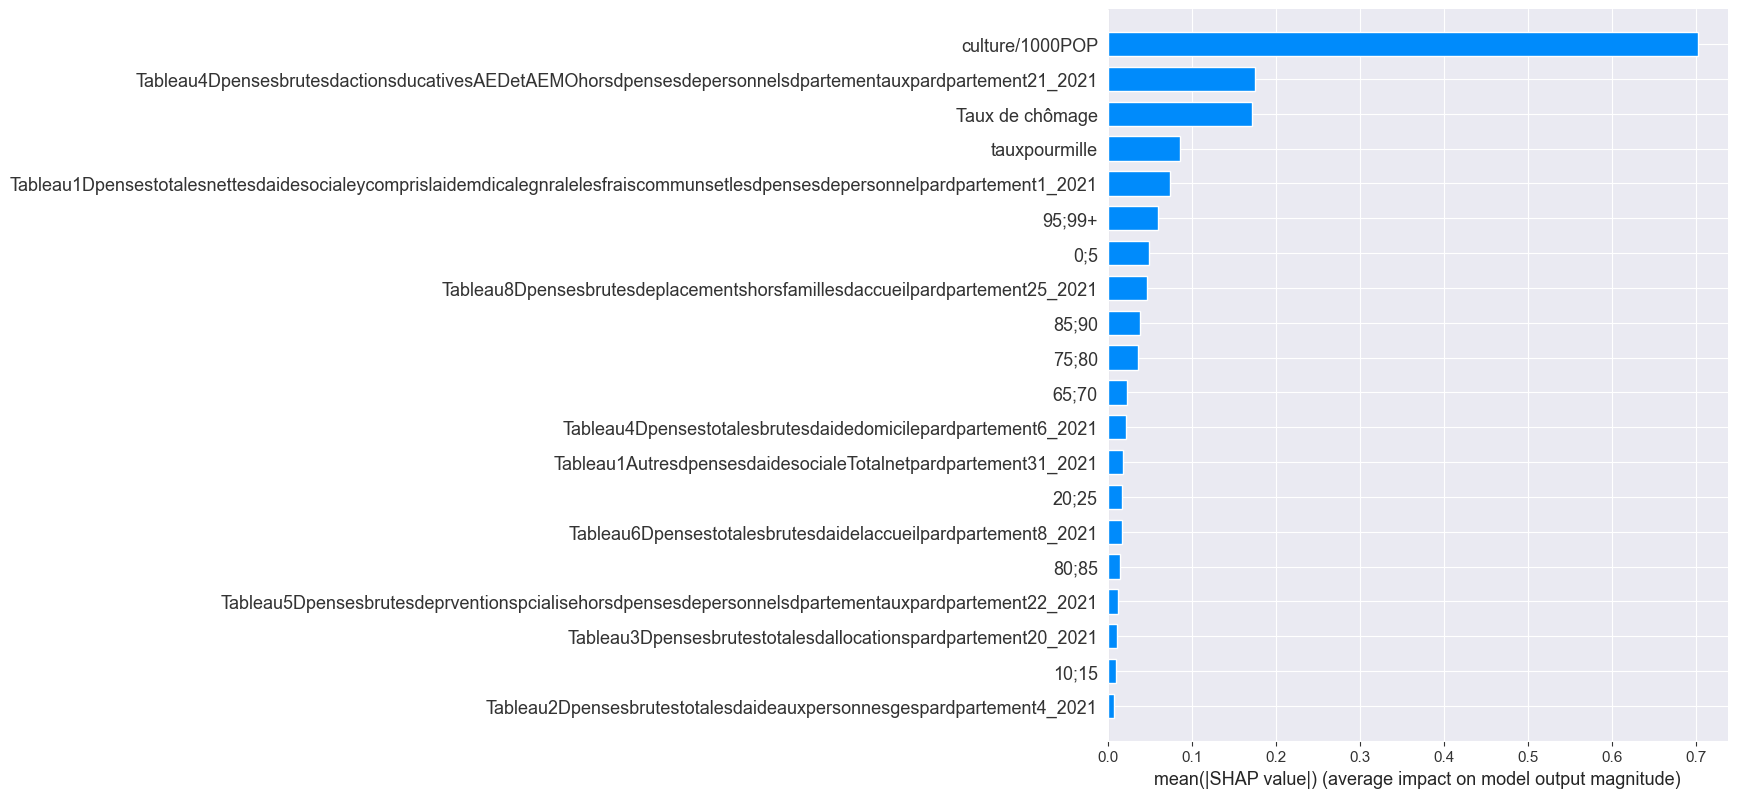

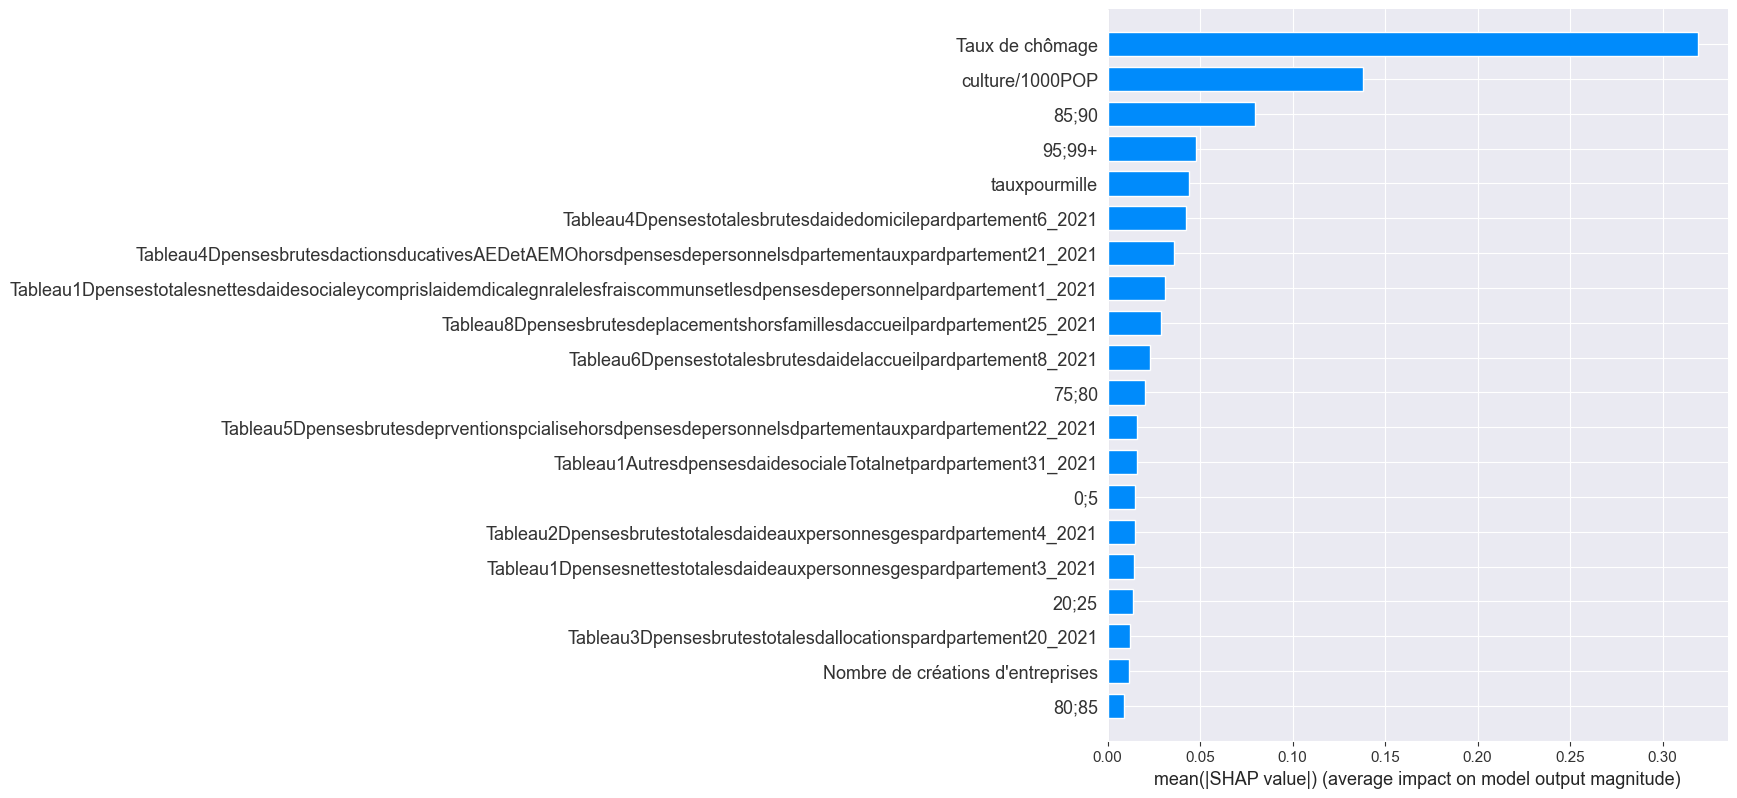

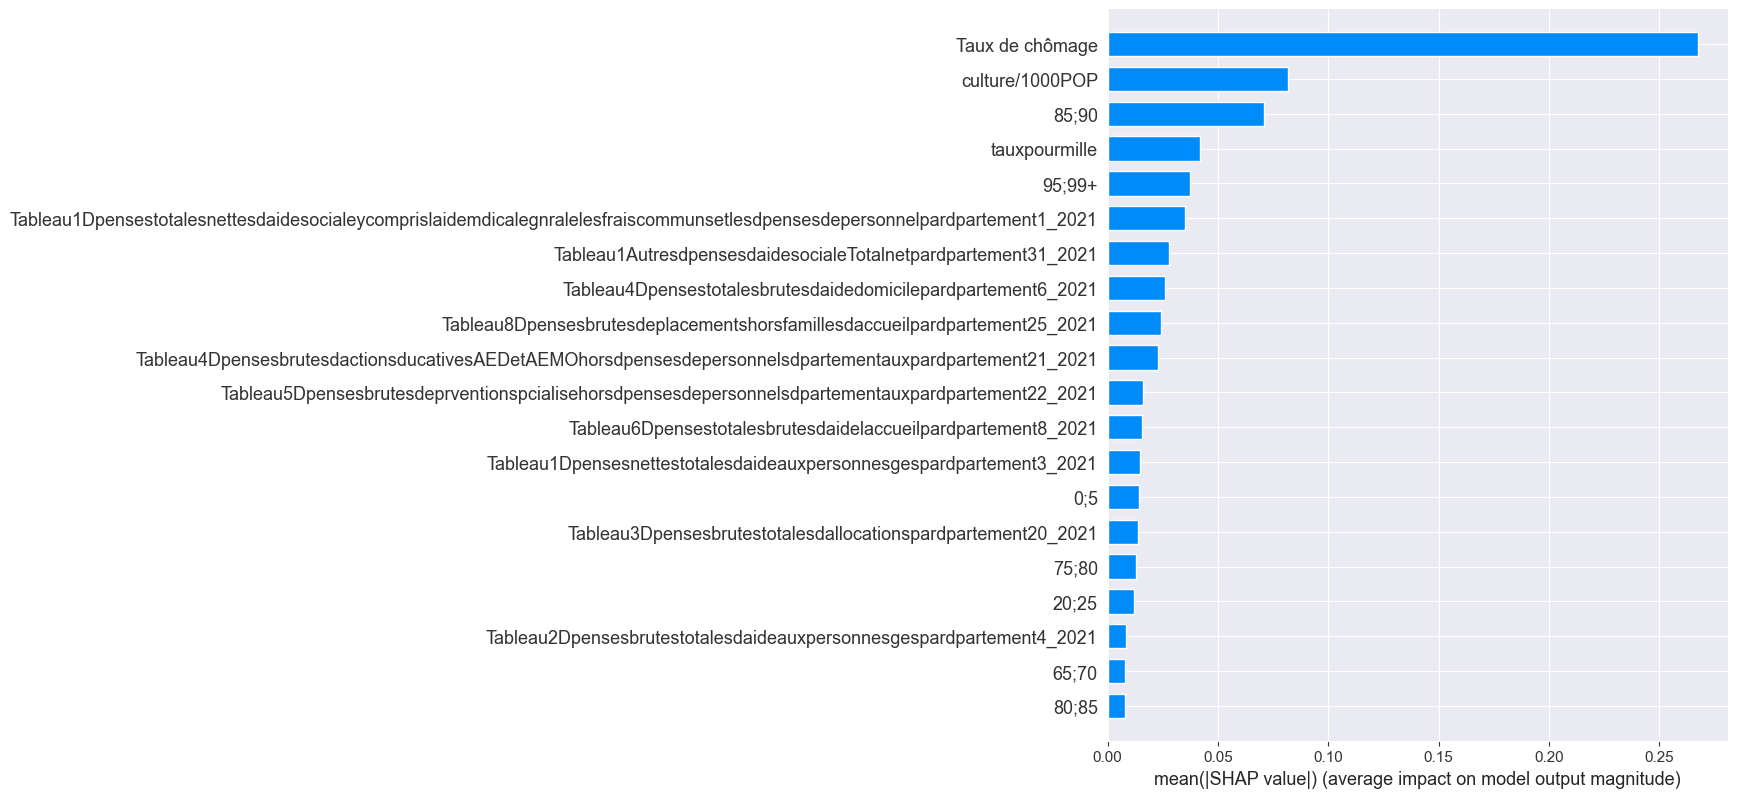

In [159]:
# Afficher les graphiques résumés des valeurs SHAP pour chaque parti politique
shap.summary_plot(shap_values_LFI, features=data_LFI.drop(columns=['gagnant']), plot_type='bar', title='LFI')
shap.summary_plot(shap_values_RN, features=data_RN.drop(columns=['gagnant']), plot_type='bar', title='RN')
shap.summary_plot(shap_values_LREM, features=data_LREM.drop(columns=['gagnant']), plot_type='bar', title='LREM')